In [1]:
# Transformer Model Notebook

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load preprocessed data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [3]:
# Define Transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward layer
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Dropout(dropout)(ff)
    return LayerNormalization(epsilon=1e-6)(x + ff)

In [4]:
# Build Transformer model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(y_train.shape[1])(x)
    return Model(inputs, outputs)

In [5]:
# Set hyperparameters
input_shape = X_train.shape[1:]
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
mlp_units = [128]
mlp_dropout = 0.4
dropout = 0.25

In [6]:
# Create and compile the model
model = build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout,
    mlp_dropout
)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 5)]              0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 10, 5)                23557     ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 10, 5)                0         ['multi_head_attention[0][0]']
                                                                                                  
 tf.__operators__.add (TFOp  (None, 10, 5)                0         ['dropout[0][0]',         

In [7]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/100
184/184 [==============================] - 28s 81ms/step - loss: 0.0560 - val_loss: 0.0081
Epoch 2/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0246 - val_loss: 0.0061
Epoch 3/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0113 - val_loss: 0.0042
Epoch 4/100
184/184 [==============================] - 14s 74ms/step - loss: 0.0066 - val_loss: 0.0041
Epoch 5/100
184/184 [==============================] - 14s 74ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 6/100
184/184 [==============================] - 14s 74ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 7/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 8/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 9/100
184/184 [==============================] - 13s 72ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 10/100
184/184 [==============================] - 13s 73ms/step - l

In [8]:
# Evaluate the model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

58/58 [==============================] - 3s 27ms/step
Mean Squared Error: 0.0022160023434067274
Mean Absolute Error: 0.025936968281638002
R-squared Score: 0.626363293642686


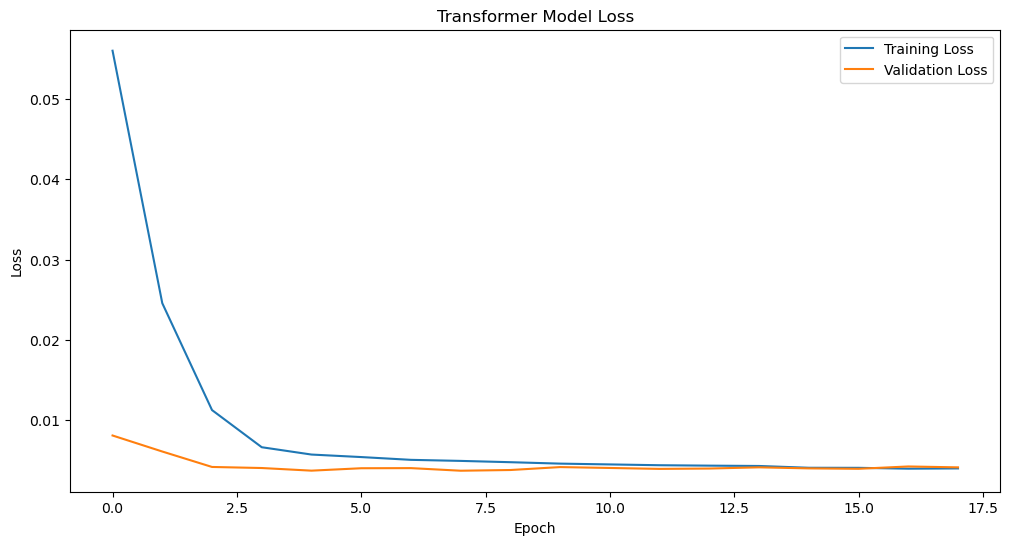

In [9]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

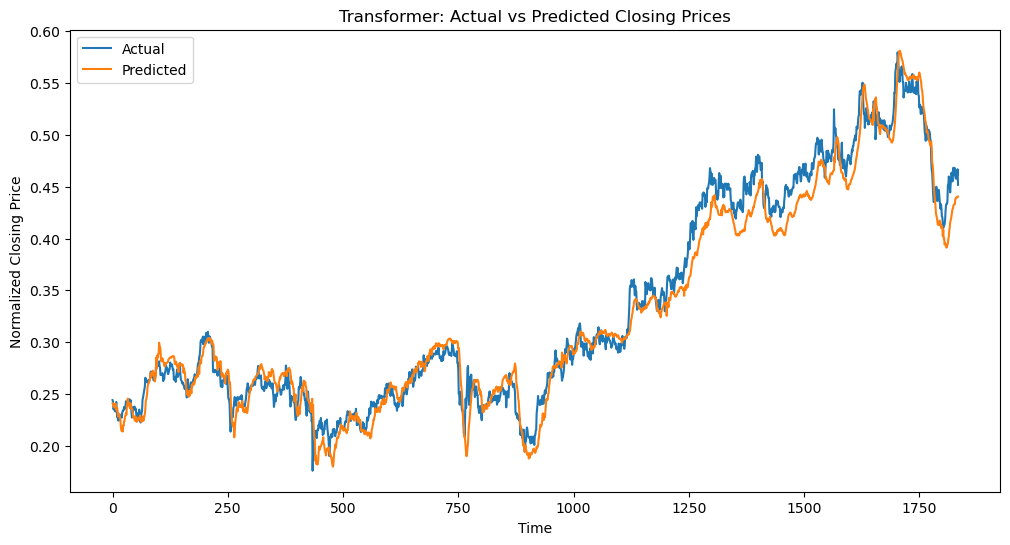

In [10]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='Actual')
plt.plot(y_pred[:, 0], label='Predicted')
plt.title('Transformer: Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Closing Price')
plt.legend()
plt.show()

F1 Score: 0.5107


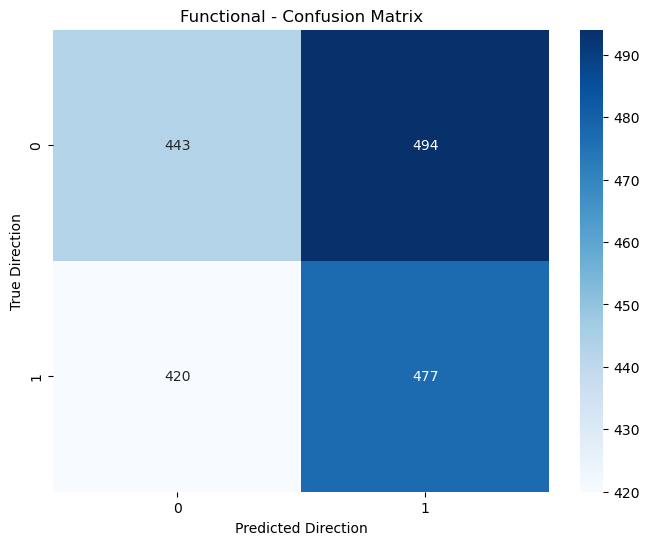

Accuracy: 0.5016
True Positive Rate (Sensitivity): 0.5318
True Negative Rate (Specificity): 0.4728
Positive Predictive Value (Precision): 0.4912
Negative Predictive Value: 0.5133


In [11]:
# Additional Evaluation Metrics

import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_additional_metrics(y_true, y_pred):
    # Calculate price movement direction
    y_true_direction = np.diff(y_true[:, 0]) > 0
    y_pred_direction = np.diff(y_pred[:, 0]) > 0

    # Compute confusion matrix
    cm = confusion_matrix(y_true_direction, y_pred_direction)

    # Compute F1 score
    f1 = f1_score(y_true_direction, y_pred_direction)

    return cm, f1

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.ylabel('True Direction')
    plt.xlabel('Predicted Direction')
    plt.show()

# Calculate additional metrics
cm, f1 = calculate_additional_metrics(y_test, y_pred)

# Print F1 score
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plot_confusion_matrix(cm, model.__class__.__name__)

# Interpret confusion matrix
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp
accuracy = (tn + tp) / total
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (Sensitivity): {tp / (tp + fn):.4f}")
print(f"True Negative Rate (Specificity): {tn / (tn + fp):.4f}")
print(f"Positive Predictive Value (Precision): {tp / (tp + fp):.4f}")
print(f"Negative Predictive Value: {tn / (tn + fn):.4f}")

Evaluation Metrics:
mse: 0.0022
mae: 0.0259
r2_score: 0.6264
accuracy: 0.5016
f1_score: 0.5107


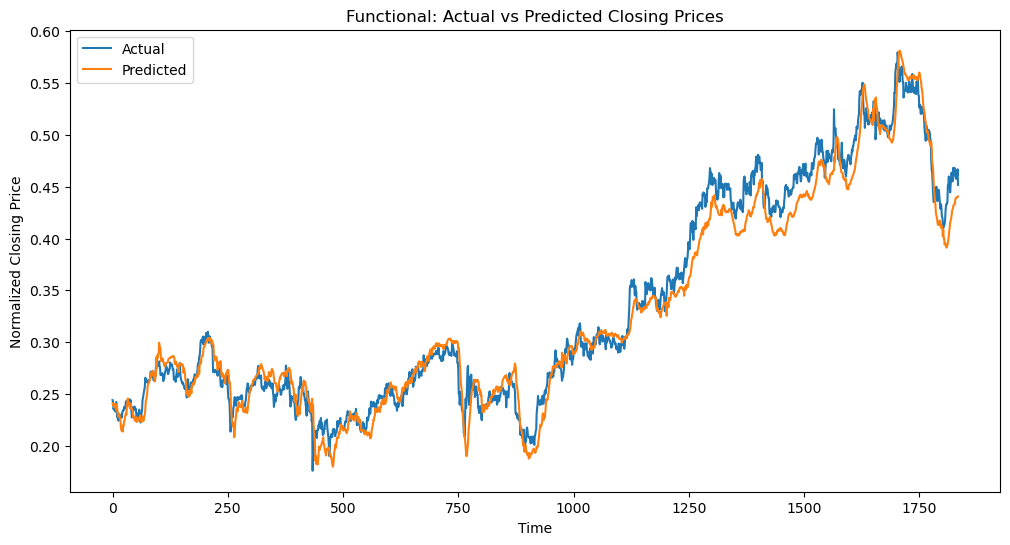

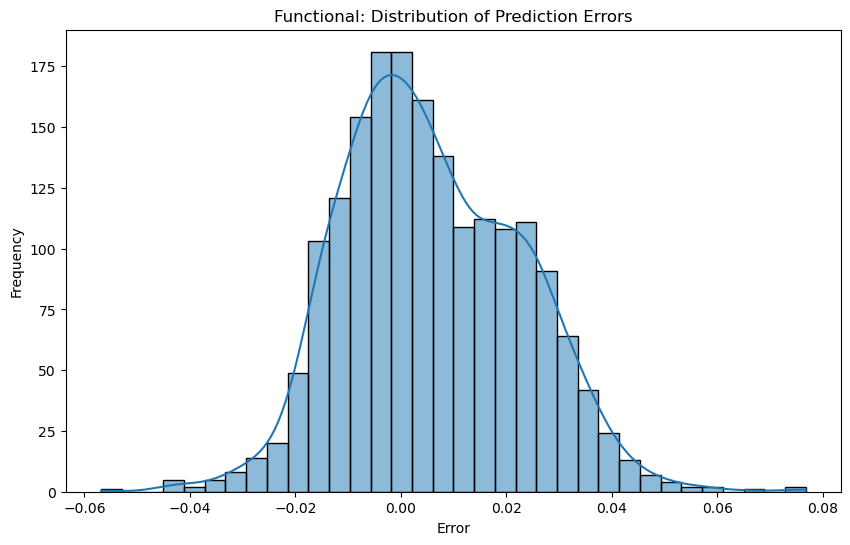

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_direction_metrics(y_true, y_pred, threshold=0):
    """
    Calculate accuracy and F-score based on the direction of price movement.
    
    :param y_true: True closing prices
    :param y_pred: Predicted closing prices
    :param threshold: Minimum change to be considered as a movement (default: 0)
    :return: Dictionary containing accuracy and F-score
    """
    # Calculate price movement direction
    y_true_direction = np.diff(y_true[:, 0]) > threshold
    y_pred_direction = np.diff(y_pred[:, 0]) > threshold
    
    # Compute accuracy and F-score
    accuracy = accuracy_score(y_true_direction, y_pred_direction)
    f1 = f1_score(y_true_direction, y_pred_direction)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1
    }

def evaluate_regression_model(y_true, y_pred):
    """
    Evaluate regression model using various metrics.
    
    :param y_true: True closing prices
    :param y_pred: Predicted closing prices
    :return: Dictionary containing evaluation metrics
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    direction_metrics = calculate_direction_metrics(y_true, y_pred)
    
    return {
        'mse': mse,
        'mae': mae,
        'r2_score': r2,
        'accuracy': direction_metrics['accuracy'],
        'f1_score': direction_metrics['f1_score']
    }

def plot_predictions(y_true, y_pred, title):
    """
    Plot true vs predicted values.
    
    :param y_true: True closing prices
    :param y_pred: Predicted closing prices
    :param title: Title of the plot
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, 0], label='Actual')
    plt.plot(y_pred[:, 0], label='Predicted')
    plt.title(f'{title}: Actual vs Predicted Closing Prices')
    plt.xlabel('Time')
    plt.ylabel('Normalized Closing Price')
    plt.legend()
    plt.show()

def plot_error_distribution(y_true, y_pred, title):
    """
    Plot the distribution of prediction errors.
    
    :param y_true: True closing prices
    :param y_pred: Predicted closing prices
    :param title: Title of the plot
    """
    errors = y_true[:, 0] - y_pred[:, 0]
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.title(f'{title}: Distribution of Prediction Errors')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

# Example usage (add this to each model notebook after making predictions):
metrics = evaluate_regression_model(y_test, y_pred)
print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

plot_predictions(y_test, y_pred, model.__class__.__name__)
plot_error_distribution(y_test, y_pred, model.__class__.__name__)